# Transfer Training and Prediction Results

In [27]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing for Limited Dataset
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

Data will be located in '../../data'
Dataset sizes: {'train': 650, 'val': 103, 'pred': 6}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


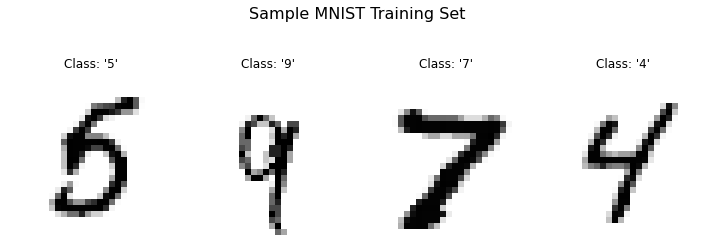

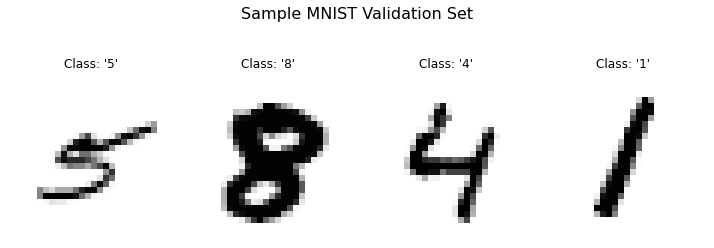

In [28]:
################################
# prepare the pre-trained model: 
#   Note the following considerations given our dataset for ResNet
#     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
#     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
#        and has 1000 output classes
#     == We must changet the last fully connected layer to match 10 classes
################################
PRETRAINED = True # <-- we will be finetunning
OUTPUT_DIR='output'
BATCH_SIZE = 32
NUM_CLASSES = 10
LIMITED_DATASET_SIZE = 650
NUM_EPOCHS = 100


data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=LIMITED_DATASET_SIZE,
                       pred_size=0.05)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# define the set to use for testing the model
inputs, labels = next(iter(dataloaders['pred']))
inputs = inputs.cuda()

# preview the dataset
dataset_preview(dataloaders['train'],'Sample MNIST Training Set')
dataset_preview(dataloaders['val'], 'Sample MNIST Validation Set')

## Train ResNet18 on the Limited Dataset

In [29]:
model_name = 'ResNet18'
model = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.fc.in_features # keep features unchanged
model.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, resnet18_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'ResNet18' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 9.3426 Acc: 0.12
val Loss: 15667117.9806 Acc: 0.0971
---------|9
Epoch 10/99
----------
train Loss: 2.308 Acc: 0.2369
val Loss: 1.9528 Acc: 0.3107
---------|19
Epoch 20/99
----------
train Loss: 1.732 Acc: 0.36
val Loss: 1.6843 Acc: 0.3786
---------|29
Epoch 30/99
----------
train Loss: 1.1643 Acc: 0.5646
val Loss: 1.063 Acc: 0.6311
---------|39
Epoch 40/99
----------
train Loss: 0.7097 Acc: 0.76
val Loss: 0.7373 Acc: 0.7379
---------|49
Epoch 50/99
----------
train Loss: 0.4662 Acc: 0.8508
val Loss: 0.7401 Acc: 0.7573
---------|59
Epoch 60/99
----------
train Loss: 0.2615 Acc: 0.9108
val Loss: 0.5233 Acc: 0.8252
---------|69
Epoch 70/99
----------
train Loss: 0.1447 Acc: 0.9585
val Loss: 0.3443 Acc: 0.9029
---------|79
Epoch 80/99
----------
train Loss: 0.0689 Acc: 0.9738
val Loss: 0.3386 Acc: 0.8835
---------|89
Epoch 90/99
----------
train Loss: 

### Let's check Resnet18 with 2x & 10x the data

In [30]:
# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=LIMITED_DATASET_SIZE*2,
                       pred_size=0.05)
resnet18_1k, resnet18_1k_sizes, _ = tmp 
print(f"Dataset sizes: {resnet18_1k_sizes}")


# Let's run with 10x the data!
model_name = 'ResNet18-1k'
model_1k = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model_1k.fc.in_features # keep features unchanged
model_1k.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model_1k.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model_1k, resnet18_1k_df,_ = train_model(device, model_1k, resnet18_1k, resnet18_1k_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-6500_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_1k_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_1k_df.columns)
print(f'> Saved results to \'{results_file}\'.')

Data will be located in '../../data'
Dataset sizes: {'train': 1300, 'val': 206, 'pred': 11}

****************************************
Training model 'ResNet18-1k' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 9.2819 Acc: 0.1546
val Loss: 16104.3293 Acc: 0.1165
---------|9
Epoch 10/99
----------
train Loss: 0.8958 Acc: 0.6915
val Loss: 0.7263 Acc: 0.767
---------|19
Epoch 20/99
----------
train Loss: 0.2538 Acc: 0.9146
val Loss: 0.4456 Acc: 0.8738
---------|29
Epoch 30/99
----------
train Loss: 0.1817 Acc: 0.9469
val Loss: 0.3563 Acc: 0.932
---------|39
Epoch 40/99
----------
train Loss: 0.0692 Acc: 0.9738
val Loss: 0.2539 Acc: 0.9272
---------|49
Epoch 50/99
----------
train Loss: 0.105 Acc: 0.9646
val Loss: 0.27 Acc: 0.9369
---------|59
Epoch 60/99
----------
train Loss: 0.0443 Acc: 0.9838
val Loss: 0.2557 Acc: 0.9466
---------|69
Epoch 70/99
----------
train Loss: 0.0591 Acc: 0.9823
val Loss: 0.3144 Acc: 0.9369
---------|79
Epoch 80/99
----------
train Loss: 

In [25]:
# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,
                       batch_size=BATCH_SIZE,
                       sample_size=6500,
                       pred_size=0.05)
resnet18_6k, resnet18_6k_sizes, _ = tmp 
print(f"Dataset sizes: {resnet18_6k_sizes}")


# Let's run with 10x the data!
model_name = 'ResNet18-6k'
model_6k = models.resnet18(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model_6k.fc.in_features # keep features unchanged
model_6k.fc = nn.Linear(num_features, NUM_CLASSES) # output layer, 10 classes
model_6k.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False) # first layer, single channel images

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model_6k, resnet18_6k_df,_ = train_model(device, model_6k, resnet18_6k, resnet18_6k_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-6500_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet18_6k_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet18_6k_df.columns)
print(f'> Saved results to \'{results_file}\'.')

Data will be located in '../../data'
Dataset sizes: {'train': 6500, 'val': 1029, 'pred': 55}

****************************************
Training model 'ResNet18-6k' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 4.3811 Acc: 0.384
val Loss: 1.3439 Acc: 0.5005
---------|9
Epoch 10/99
----------
train Loss: 0.2056 Acc: 0.9372
val Loss: 0.1323 Acc: 0.9563
---------|19
Epoch 20/99
----------
train Loss: 0.1075 Acc: 0.9666
val Loss: 0.0895 Acc: 0.9747
---------|29
Epoch 30/99
----------
train Loss: 0.0569 Acc: 0.9831
val Loss: 0.0849 Acc: 0.9806
---------|39
Epoch 40/99
----------
train Loss: 0.1778 Acc: 0.9491
val Loss: 0.1068 Acc: 0.9689
---------|49
Epoch 50/99
----------
train Loss: 0.0908 Acc: 0.9732
val Loss: 0.0948 Acc: 0.9757
---------|59
Epoch 60/99
----------
train Loss: 0.03 Acc: 0.9905
val Loss: 0.068 Acc: 0.9806
---------|69
Epoch 70/99
----------
train Loss: 0.0284 Acc: 0.9906
val Loss: 0.0878 Acc: 0.9815
---------|79
Epoch 80/99
----------
train Loss: 0.

             training_time  validation_time
model                                      
resnet18         49.456210        70.330232
resnet18_1k      90.678120       116.710145
resnet18_6k     286.254481       326.671497



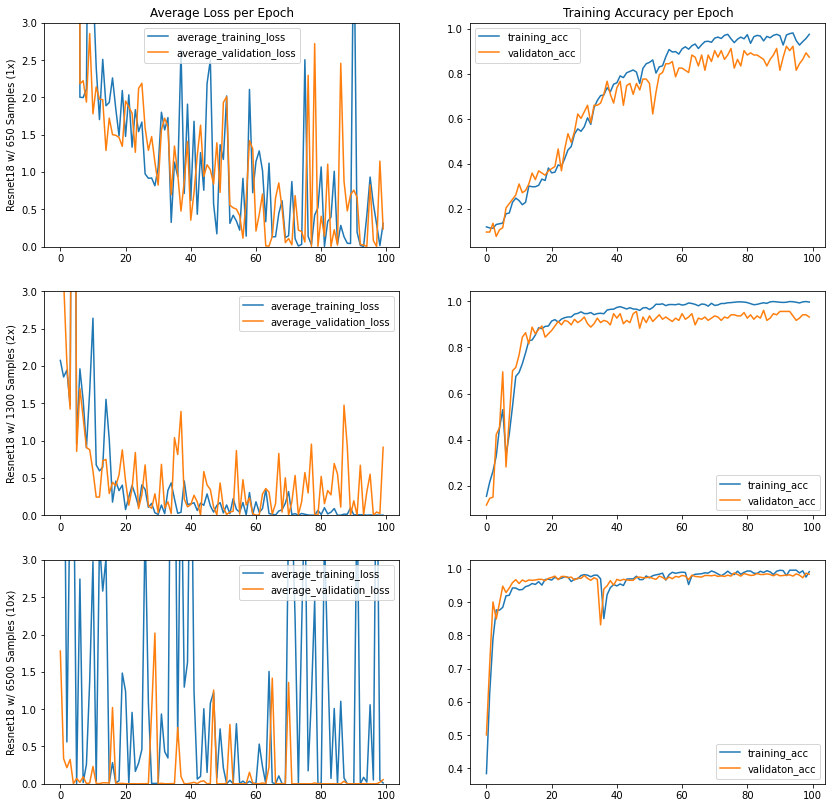

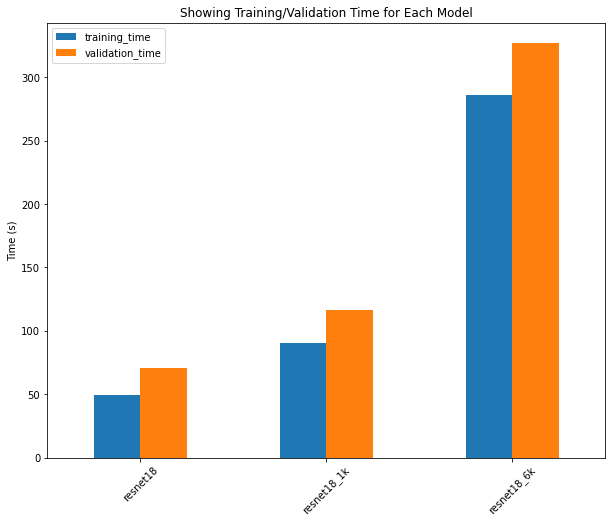

In [31]:
## Compare all of the training/validation times
# collect all model outputs
model_dict = {'resnet18': resnet18_df, 'resnet18_1k': resnet18_1k_df,'resnet18_6k': resnet18_6k_df}
dfs = []
for m in model_dict: 
    # do some cleanup and make a model column
    df = model_dict[m].set_index('epoch').copy()
    df['model'] = m
    dfs.append(df)
    
# plot performance curves
loss_df = pd.concat(dfs).groupby(['model'])[["average_training_loss", "average_validation_loss"]]
acc_df = pd.concat(dfs).groupby(['model'])[["training_acc", "validaton_acc"]]

fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(14,14))
resnet18_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[0,0])
resnet18_1k_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[1,0])
resnet18_6k_df.plot(y=['average_training_loss','average_validation_loss'], ax=axes[2,0])

axes[0,0].set_ylim([0,3])
axes[1,0].set_ylim([0,3])
axes[2,0].set_ylim([0,3])

resnet18_df.plot(y=['training_acc','validaton_acc'],ax=axes[0,1])
resnet18_1k_df.plot(y=['training_acc','validaton_acc'],ax=axes[1,1])
resnet18_6k_df.plot(y=['training_acc','validaton_acc'],ax=axes[2,1]).get_figure()

# titles and such
axes[0,0].set_title('Average Loss per Epoch')
axes[0,1].set_title('Training Accuracy per Epoch')
axes[0,0].set_ylabel('Resnet18 w/ 650 Samples (1x)')
axes[1,0].set_ylabel('Resnet18 w/ 1300 Samples (2x)')
axes[2,0].set_ylabel('Resnet18 w/ 6500 Samples (10x)')
# Save the plots
img_file = f'loss_transfer-mnist_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))



# concatenetate all model results and sum up the times
time_df = pd.concat(dfs) \
            .groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig2 = time_df.plot.bar(figsize=(10,8)).get_figure()
plt.title('Showing Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

# Save the plots
img_file = f'time_transfer-mnist_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig2.savefig(os.path.join(OUTPUT_DIR,img_file))

## Evaluate ResNet18s

NameError: name 'model_6k' is not defined

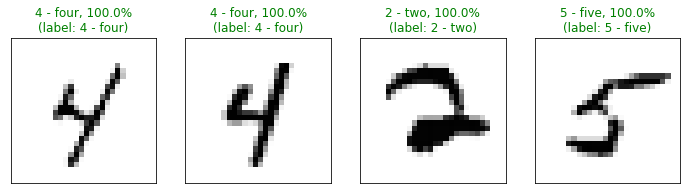

In [12]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()


model_6k.eval()
# make predictions an plot the results
fig = plot_classes_preds(model_6k,inputs,labels,class_names) 
plt.plot()





### Preliminary look at training/validation time

          training_time  validation_time
model                                   
resnet18      45.276058        62.294495



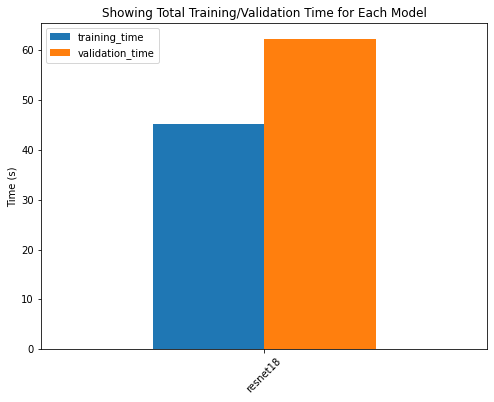

In [17]:
## Compare all of the training/validation times
df = resnet18_df.set_index('epoch').copy()
df['model'] = 'resnet18'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6))
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

## Train ResNet50 on the Limited Dataset

In [16]:
model_name = 'ResNet50'
model = models.resnet50(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, resnet50_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
resnet50_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=resnet50_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'ResNet50' with limited dataset size of 650...

Epoch 0/99
----------
train Loss: 12.3011 Acc: 0.1108
val Loss: 589411298174.7573 Acc: 0.1068
---------|9
Epoch 10/99
----------
train Loss: 1.6694 Acc: 0.4092
val Loss: 1.729 Acc: 0.4175
---------|19
Epoch 20/99
----------
train Loss: 1.061 Acc: 0.6292
val Loss: 1.4909 Acc: 0.5437
---------|29
Epoch 30/99
----------
train Loss: 1.0415 Acc: 0.6585
val Loss: 1.259 Acc: 0.6214
---------|39
Epoch 40/99
----------
train Loss: 0.8667 Acc: 0.6923
val Loss: 1.2613 Acc: 0.5922
---------|49
Epoch 50/99
----------
train Loss: 0.3656 Acc: 0.8692
val Loss: 0.946 Acc: 0.699
---------|59
Epoch 60/99
----------
train Loss: 0.2877 Acc: 0.9
val Loss: 0.9815 Acc: 0.7961
---------|69
Epoch 70/99
----------
train Loss: 0.1761 Acc: 0.9308
val Loss: 1.0251 Acc: 0.7573
---------|79
Epoch 80/99
----------
train Loss: 0.2063 Acc: 0.9369
val Loss: 0.9283 Acc: 0.8155
---------|89
Epoch 90/99
----------
train 

## Evaluate ResNet50

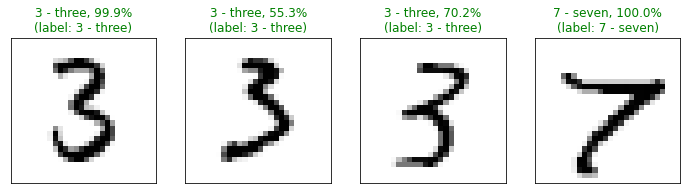

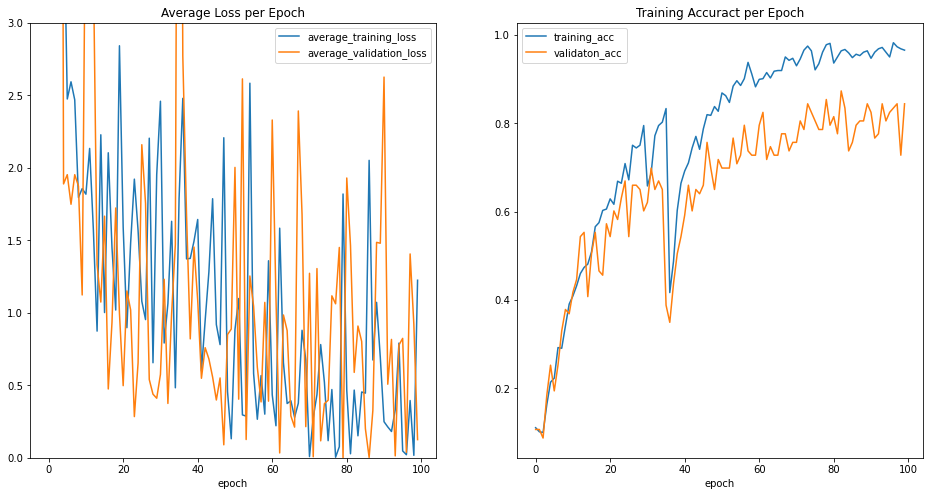

In [18]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
resnet50_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
resnet50_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

          training_time  validation_time
model                                   
resnet50      83.620959       106.417532



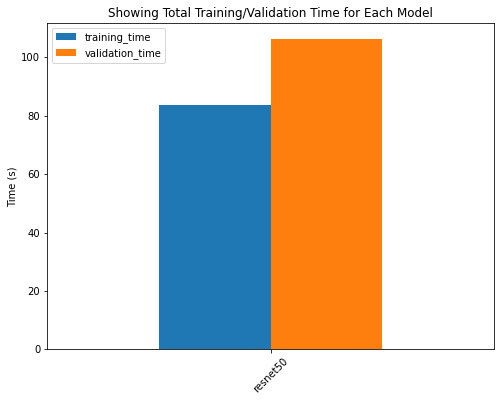

In [19]:
## Compare all of the training/validation times
df = resnet50_df.set_index('epoch').copy()
df['model'] = 'resnet50'
# concatenetate all model results and sum up the times
time_df = df.groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
fig = time_df.plot.bar(figsize=(8,6))
plt.title('Showing Total Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()

## Train VGG11 on the Limited Dataset

In [95]:
model_name = 'VGG11'
model = models.vgg11(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.classifier[6].in_features
model.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model.features = torch.nn.Sequential(*[model.features[ii] for ii in range(15)])
model.classifier = torch.nn.Sequential(*[model.classifier[jj] for jj in range(4)])
model.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, vgg11_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
vgg11_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=vgg11_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'VGG11' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: nan Acc: 0.1015
val Loss: nan Acc: 0.1068
--------|8
Epoch 9/9
----------
train Loss: nan Acc: 0.0985
val Loss: nan Acc: 0.1068
Training complete in 0.0m 7.063429117202759s
Best val Acc: 0.1068
> Saved results to 'VGG11_size-650_results_2020-12-16T030442.csv'.


## Evaluate VGG11

[]

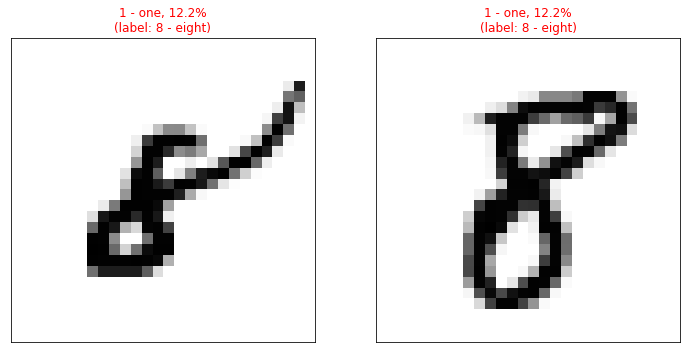

In [17]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
vgg11_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
vgg11_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Train VGG16 on the Limited Dataset

In [96]:
model_name = 'VGG16'
model = models.vgg16(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
num_features = model.classifier[6].in_features
model.features[0] = torch.nn.Conv2d(1, 64, 3, 1, 1)
model.features = torch.nn.Sequential(*[model.features[ii] for ii in range(23)])
model.classifier = torch.nn.Sequential(*[model.classifier[jj] for jj in range(4)])
model.classifier[-1] = torch.nn.Linear(num_features, NUM_CLASSES)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, vgg16_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)
# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
vgg16_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=vgg16_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'VGG16' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: nan Acc: 0.0754
val Loss: nan Acc: 0.1068
--------|8
Epoch 9/9
----------
train Loss: nan Acc: 0.0985
val Loss: nan Acc: 0.1068
Training complete in 0.0m 7.566320419311523s
Best val Acc: 0.1068
> Saved results to 'VGG16_size-650_results_2020-12-16T030450.csv'.


## Evaluate VGG16

[]

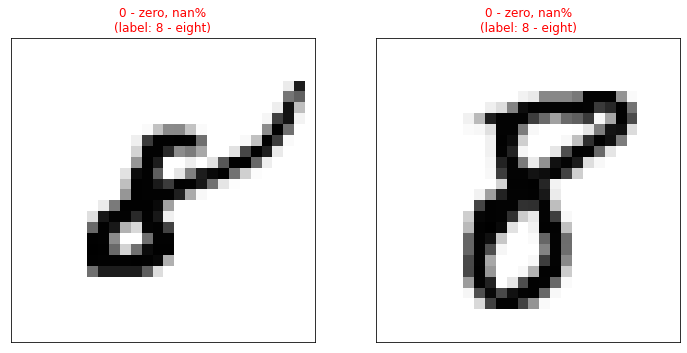

In [19]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
vgg16_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
vgg16_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Train DenseNet161 on the Limited Dataset

In [97]:
model_name = 'DenseNet161'
model =  models.densenet161(pretrained=PRETRAINED)
# modify the network to work with MNIST 28x28x1 with 10 outputs
model.features.conv0 = torch.nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.features.pool0 = torch.nn.Identity()
model.classifier = torch.nn.Linear(2208, NUM_CLASSES, bias=True)

# use helper function to train the model (outputs model and Pandas DF)
print('\n'+'*'*40)
print(f'Training model \'{model_name}\' with limited dataset size of {LIMITED_DATASET_SIZE}...')
cudnn.benchmark = True
model, densnet161_df,_ = train_model(device, model, dataloaders, dataset_sizes, 
                                   output_dir=OUTPUT_DIR, status=10,
                                    num_epochs=NUM_EPOCHS)

# save the data for others to use
 # <-- train_model should have created this dir
results_file = f'{model_name}_size-{LIMITED_DATASET_SIZE}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
densnet161_df.to_csv(os.path.join(OUTPUT_DIR,results_file),
                  columns=densnet161_df.columns)
print(f'> Saved results to \'{results_file}\'.')


****************************************
Training model 'DenseNet161' with limited dataset size of 650...

Epoch 0/9
----------
train Loss: 10.6758 Acc: 0.0908
val Loss: 6591462280288634.0 Acc: 0.0874
--------|8
Epoch 9/9
----------
train Loss: 1.5676 Acc: 0.4754
val Loss: 1.5038 Acc: 0.4563
Training complete in 0.0m 30.757423162460327s
Best val Acc: 0.5146
> Saved results to 'DenseNet161_size-650_results_2020-12-16T030522.csv'.


## Evaluate DesneNet161

In [ ]:
# Evaluate the model using the prediction set held-off
model.eval()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

# plot performance curves
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
densnet161_df.plot(x='epoch', y=['average_training_loss','average_validation_loss'],ax=axes[0])
axes[0].set_title('Average Loss per Epoch')
axes[0].set_ylim([0,3])
densnet161_df.plot(x='epoch', y=['training_acc','validaton_acc'],ax=axes[1])
axes[1].set_title('Training Accuract per Epoch')

img_file = f'loss_{model_name}_{time.strftime("%Y-%m-%dT%H%M%S")}.png'
fig.savefig(os.path.join(OUTPUT_DIR,img_file))

## Compare times from all models

          training_time  validation_time
model                                   
resnet18       4.524335         6.353591
resnet50       8.302803        10.551234
vgg11          4.420199         6.074397
vgg16          4.839115         6.552462



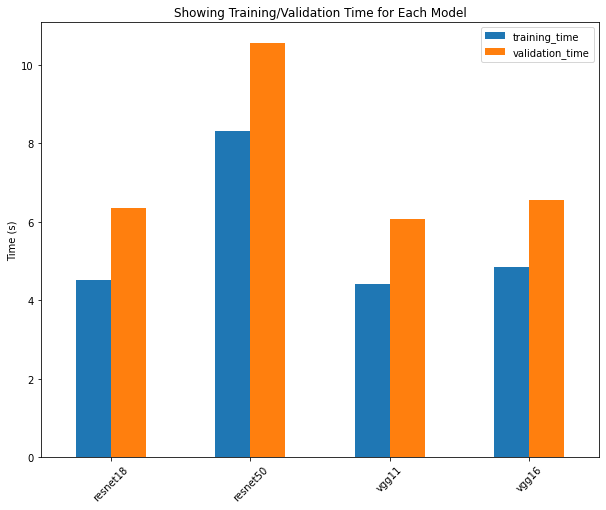

In [105]:
## Compare all of the training/validation times
# collect all model outputs
model_dict = {'resnet18': resnet18_df, 'resnet50': resnet50_df,'vgg11':vgg11_df,'vgg16':vgg16_df}
dfs = []
for model in models: 
    # do some cleanup and make a model column
    df = model_dict[model].set_index('epoch').copy()
    df['model'] = model
    dfs.append(df)
# concatenetate all model results and sum up the times
time_df = pd.concat(dfs) \
            .groupby(['model'])[["training_time", "validation_time"]] \
            .apply(lambda x : x.astype(float).sum())

# show the times
print(time_df)
print()
# plot the times
time_df.plot.bar(figsize=(10,8))
plt.title('Showing Training/Validation Time for Each Model')
# other it'll show up as 'dummy' 
plt.ylabel('Time (s)')
plt.xlabel('')
plt.xticks(rotation=45)
plt.show()